In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from activation_utils import load_model
import json
from tqdm import tqdm
from activation_utils import get_activation_cache_for_entity
from dataset_utils import generate_base_source_dataset
import os
import numpy as np
import matplotlib.pyplot as plt


torch.set_grad_enabled(False)

/share/u/can/miniconda3/envs/reference_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_id = "google/gemma-2-2b"
model = load_model(model_id)
model.tokenizer.pad_token = model.tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


In [4]:
from generation import is_equal

def retrieve_key_from_generation(base, generation):
    for key, word in base['key_to_word'].items():
        if is_equal(word, generation):
            return key

In [15]:
from transformers import BatchEncoding

def generate_with_intervention(model, base, source, source_act_LD, layers):
    token_ids = base["token_ids"][: -base["num_right_pad"]]
    attention_mask = base["attention_masks"][: -base["num_right_pad"]]
    token_ids = torch.tensor(token_ids).unsqueeze(0).to(model.device)
    attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(model.device)
    encoding = BatchEncoding({"input_ids": token_ids, "attention_mask": attention_mask})

    base_intervention_pos = base['key_to_position']['a_question']

    with model.generate(encoding, max_new_tokens=1):
        for layer_idx, layer in enumerate(layers):
            resid_BLD = model.model.layers[layer].output[0]
            resid_BLD[:, base_intervention_pos, :] = source_act_LD[layer_idx]
            model.model.layers[layer].output = (resid_BLD,)
        generation = model.generator.output.save()
    generation = model.tokenizer.decode(generation[0, -1])

    return generation

labels = ["source_pointer", "source_box", "source_object", "base_object", "other_base_object", "other_source_object", "total_mismatch"]
def evaluate_intervention(generation, base, source):
    if is_equal(generation, base['special_str']["base_object_from_source_box_pointer"]):
        return np.array([1, 0, 0, 0, 0, 0, 0])
    elif is_equal(generation, base['special_str']["base_object_from_source_qbox_in_base"]):
        return np.array([0, 1, 0, 0, 0, 0, 0])
    elif is_equal(generation, base['special_str']["source_object"]):
        return np.array([0, 0, 1, 0, 0, 0, 0])
    elif is_equal(generation, base['special_str']["correct_base_object"]):
        return np.array([0, 0, 0, 1, 0, 0, 0])
    elif any([is_equal(generation, word) for word in base['key_to_word'].values()]):
        return np.array([0, 0, 0, 0, 1, 0, 0])
    elif any([is_equal(generation, word) for word in source['key_to_word'].values()]):
        return np.array([0, 0, 0, 0, 0, 1, 0])
    else: # total_mismatch
        return np.array([0, 0, 0, 0, 0, 0, 1])


In [16]:
# Example usage
num_samples_per_order_pair = 20 # post filter
random_offset = True
ctx_length_with_pad = 100
# layers = list(range(model._model.config.num_hidden_layers))
layers = [12]

# template_name = "box_templates"
# base_entity_name = "common_objects1"
# source_entity_name = "common_objects2"
# attribute_name = "letter"

# template_name = "homecountry_templates"
# base_entity_name = "first_names1"
# source_entity_name = "first_names2"
# attribute_name = "country"

template_name = "time_templates"
base_entity_name = "first_names1"
source_entity_name = "first_names2"
attribute_name = "weekday"

# dataset_path = f'data/base_source_dataset_{template_name}.json'
# activation_path = f'data/source_activations_{template_name}.json'

dataset_path = f'data/base_source_dataset_time_templates.json'
activation_path = f'data/source_activations_box_templates.json'
force_recompute = False

In [17]:
if force_recompute or not os.path.exists(dataset_path):
    base_dataset, source_dataset = generate_base_source_dataset(
        model, 
        num_samples_per_order_pair, 
        template_name=template_name,
        base_entity_name=base_entity_name,
        source_entity_name=source_entity_name,
        attribute_name=attribute_name,
        tokenizer=model.tokenizer, 
        ctx_length_with_pad=ctx_length_with_pad, 
        random_offset=random_offset,
        save_path=dataset_path,
    )
else:
    with open(dataset_path, 'r') as f:
        both_datasets = json.load(f)
    base_dataset = both_datasets['base_dataset']
    source_dataset = both_datasets['source_dataset']

In [18]:
# Get activations for source dataset
if force_recompute or not os.path.exists(activation_path):
    act_LBED, pos_LE = get_activation_cache_for_entity(
        model,
        source_dataset,
        layers,
        save_activations_path=activation_path,
        save_positions_path=None,
    )
else:
    with open(activation_path, 'rb') as f:
        act_LBED = torch.load(f)

/tmp/ipykernel_3377397/3620868153.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_LBED = torch.load(f)


In [19]:
with open(activation_path, 'rb') as f:
    act_LBED = torch.load(f)

# Do interventions
outcomes = np.array([0, 0, 0, 0, 0, 0, 0])
for i, (base, source) in tqdm(enumerate(zip(base_dataset, source_dataset)), total=len(base_dataset), desc="Interventions"):
    gen = generate_with_intervention(model, base, source, act_LBED[:, i, -1], layers)
    out = evaluate_intervention(gen, base, source)
    outcomes += out
    # if out[4] == 1:
    #     print(source['text'])
    #     print(base['text'])
    #     print(base['special_str'])
    #     print(gen)
    #     print(out)
    #     break

print(outcomes)

/tmp/ipykernel_3377397/720763134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_LBED = torch.load(f)
Interventions:   0%|          | 0/400 [00:00<?, ?it/s]

Interventions: 100%|██████████| 400/400 [00:14<00:00, 27.42it/s]

[193  18   0  83  31   0  75]


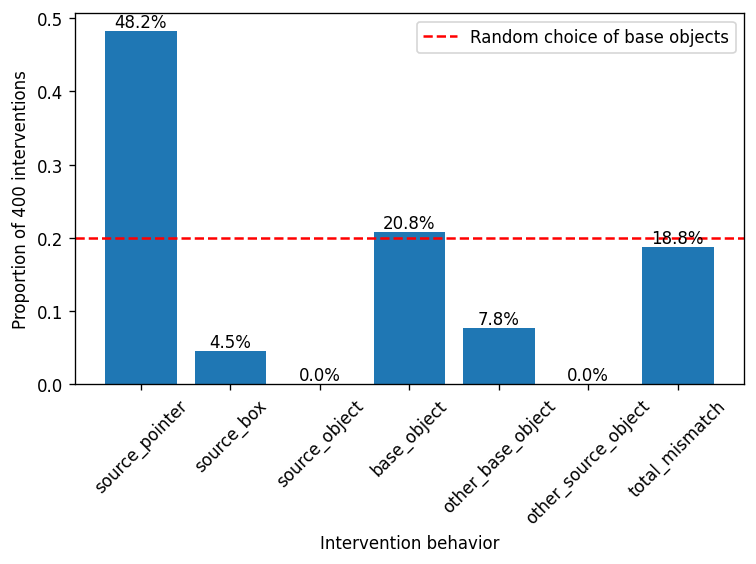

In [20]:
def plot_outcomes(outcomes, labels):
    # Calculate percentages as proportions between 0 and 1
    proportions = outcomes / outcomes.sum()

    fig, ax = plt.subplots(dpi=120)
    bars = ax.bar(labels, proportions)
    plt.xticks(rotation=45)

    # Add percentage labels above each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',  # Convert proportion to percentage for display
                ha='center', va='bottom')

    plt.title("")
    plt.ylabel(f"Proportion of {sum(outcomes)} interventions")
    plt.xlabel("Intervention behavior")

    # constant line for baseline accuracy
    plt.axhline(y=0.2, color='r', linestyle='--', label='Random choice of base objects')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_outcomes(outcomes, labels)

# Can I intervene with mean vectors better than with random vectors?

In [21]:
# # compute mean vectors
num_relations = len(source_dataset[0]['entity_keys'])
source_relation_orders = [int(source['question']['answer_key'][1:]) for source in source_dataset]
source_mean_LRD = torch.zeros((len(layers), num_relations, model._model.config.hidden_size))

for relation_idx in range(num_relations):
    mask = torch.tensor(source_relation_orders) == relation_idx
    source_mean_LRD[:, relation_idx] = torch.mean(act_LBED[:, mask, -1, :], dim=1)

# save mean vectors
source_mean_path = f'data/source_mean_activations_{"box_templates"}.pt'
# torch.save(source_mean_LRD, source_mean_path)

# load mean vectors
with open(source_mean_path, 'rb') as f:
    source_mean_LRD = torch.load(f)

/tmp/ipykernel_3377397/2353138739.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_mean_LRD = torch.load(f)


In [22]:
# Do interventions
mean_outcomes = np.array([0, 0, 0, 0, 0, 0, 0])
for i, (base, source) in tqdm(enumerate(zip(base_dataset, source_dataset)), total=len(base_dataset), desc="Interventions"):
    source_relation_order = source_relation_orders[i]
    source_mean_LD = source_mean_LRD[:, source_relation_order, :]
    gen = generate_with_intervention(model, base, source, source_mean_LD, layers)
    out = evaluate_intervention(gen, base, source)
    mean_outcomes += out
    # if out[4] == 1:
    #     print(source['text'])
    #     print(base['text'])
    #     print(base['special_str'])
    #     print(gen)
    #     print(out)
    #     break

print(mean_outcomes)

Interventions:   1%|          | 3/400 [00:00<00:17, 23.09it/s]

Interventions: 100%|██████████| 400/400 [00:14<00:00, 27.85it/s]

[241  10   0  71  28   0  50]


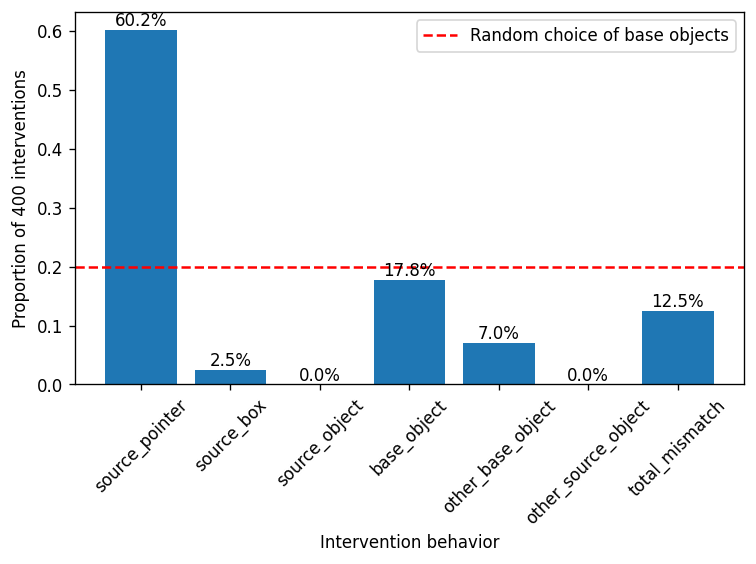

In [23]:
plot_outcomes(mean_outcomes, labels)